In [1]:
pip install alpaca-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.6.3
    Uninstalling pydantic_core-2.6.3:
      Successfully uninstalled pydantic_core-2.6.3
  Attempting uninstall: annotated-types
    Found existing installation: annotated-types 0.5.0
    Uninstalling annotated-types-0.5.0:
      Successfully uninstalled annotated-types-0.5.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.12
    Uninstalling pydantic-1.10.12:
      Successfully uninstalled pydantic-1.10.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4

Overtake sp500 by Anatolii Frolov

# Ideas

I've started with brainstorming 
- Come up with an idea for bitcoin
- Pairs 
- Basic ml approach
- Wholy grail of unknowness

## Bitcoin idea

The whole idea was based on the story of my junky friend that liked to use drugs 
- Idea
    - His ritual consisted of using btc converter online(before p2p) this transactions would boost the volume exponentioanlly 
    - I choose the moscow region as there are more junkies in this territory , moreover , time frame like in HFD analysis (with dummy for each hour) was estimated to be 5/7 pm
    - this constant boost of volatility would result in an incresase in price of option (binary options as an example) as in theory we have an increase in price due to an increase in volatility 
- Problems
    - THere is a problem as we weren't allowed to use anything but sp500 
    - I have to use not so legal ways of tracking ex hydra wallets
    (DNMM)

## Pair trading

This idea consists of a research that i saw in google scholar: lower freefloat(public float)
- DOI: 0.1177/0972652712454518
- The idea proposed a lag inbetween trades of a liqiuid stock and illiquid stock
- The more liquid asset tend to react normally 
- The less liqiud asset has a tendency to overreact -> We have a spread 
 

Example: </br>
We have bad news: sugar is banned : Coca-cola and pepsi have a problem, they have to discontinue and get rid of all product  -> liqiuid asset drops by 20% but illiqiud asset drops by 25 percent (imagining we have perfect) </br>
We can abuse the situation by shorting less liqiud company and buying more liqiud -> earning a profit </br>
This is under assumption that the impact's significance is expolred already i.e. we know the direction of the move : </br>
this move can be acquired by scraping data from yahoofinance etc and using [this weights for BERT](https://huggingface.co/fuchenru/Trading-Hero-LLM)

## Basic ml approach

Last resort is to just train on features like 
- Candles
- Volume
- Closing price
- Correlation
- Rates guessing 
- Info dumping

## Order driven 

The main idea comes from the paper + [Glosten-Milgrom](https://www.sciencedirect.com/science/article/pii/0304405X85900443) that i left in the folder called paper: it stands on the idea of LOB, very common thing in QT

In this paper author introduces some assumptions and uses simple <mark>brownian motion</mark> which is a way to imporve the profitability of this strategy
</br> we will look at some interesting ideas regarding it sooner or later 
</br> Moreover, I spotted a place for interest at the point of little to no research of second derivative of investors utility function
</br> Here we assume rationality , even though in the text it's written othwerwise but still

In Section 2.1 and 2.2 we make some observation about investors bid and ask that are essential from even psychological way of thinking:</br>
We can say that (from 2.3) that the close we are to liquidation time the less risk we bear (T-t) </br>
</br>It depends on bid ask apread , it mainly has to do with timing of the purchase, however, it might be seen as drowdown compilator 
</br> Because it's again based on the fact of exiting point existing and we might have a problem with how to detect  profit exit point
</br> For that I suggest to check the maximum difference between open and close price and find the variance </br>
The whole idea of the project is to find out whether proved strategy can result in similar output

Moreover, I will have to make more features , because there is not enough info as I  Can't operate at HFD capacity, therefore, the strategy might not work, but for the feature </br> This can be tested on the HFD data  

The main weak points of most of the strategies are seen as a slop features and low performance due to a choice of a model </br>
Even though , As i've made a research, we can make a tradeoff between stacking Xgbs with difffrent structutres and inputs , we can optimize good or so </br>
performance using linreg with good enough coefficients that interact with each other </br>
I will try to generate as much features as I can, moreover, i saw a weights for [model](https://huggingface.co/mrzlab630/lora-alpaca-trading-candles)
 that returns the direction and volumes of the candels we can actually try to use it 

So the plan is like this
- We download the data from alpaca -api
- We try to clean the data not by using standard scaler BUT
    - domain-aware transformations , I was told to undersatnd what i want from the transformations
        - I'm aware that returns are not normal and using Standard Scaler will result into bad misunderstanding of data of equity, therefore we have to make it Gaussian enough 
        to even try using LinReg efficiently
        - We can be helped by Yeo-Johson Transformation that is very efficient of transforming by using the concept of power function (literally Normal under some circum)
- Now, that we have Gaussian data we work on the features 
    - will try to explain features later
- Then we backtest 
    - will be using vbt most definately

Also , i've decided to make real-real strategy: 
- We will be optimizing a rolling window for ML model instead of using one trained on the whole bunch data because returns (when adjusted) are just Gaussian noise
- So , i will just fit linear regression everytime for in-sample obersavions 

In [50]:

from PIL import Image
from IPython.display import display

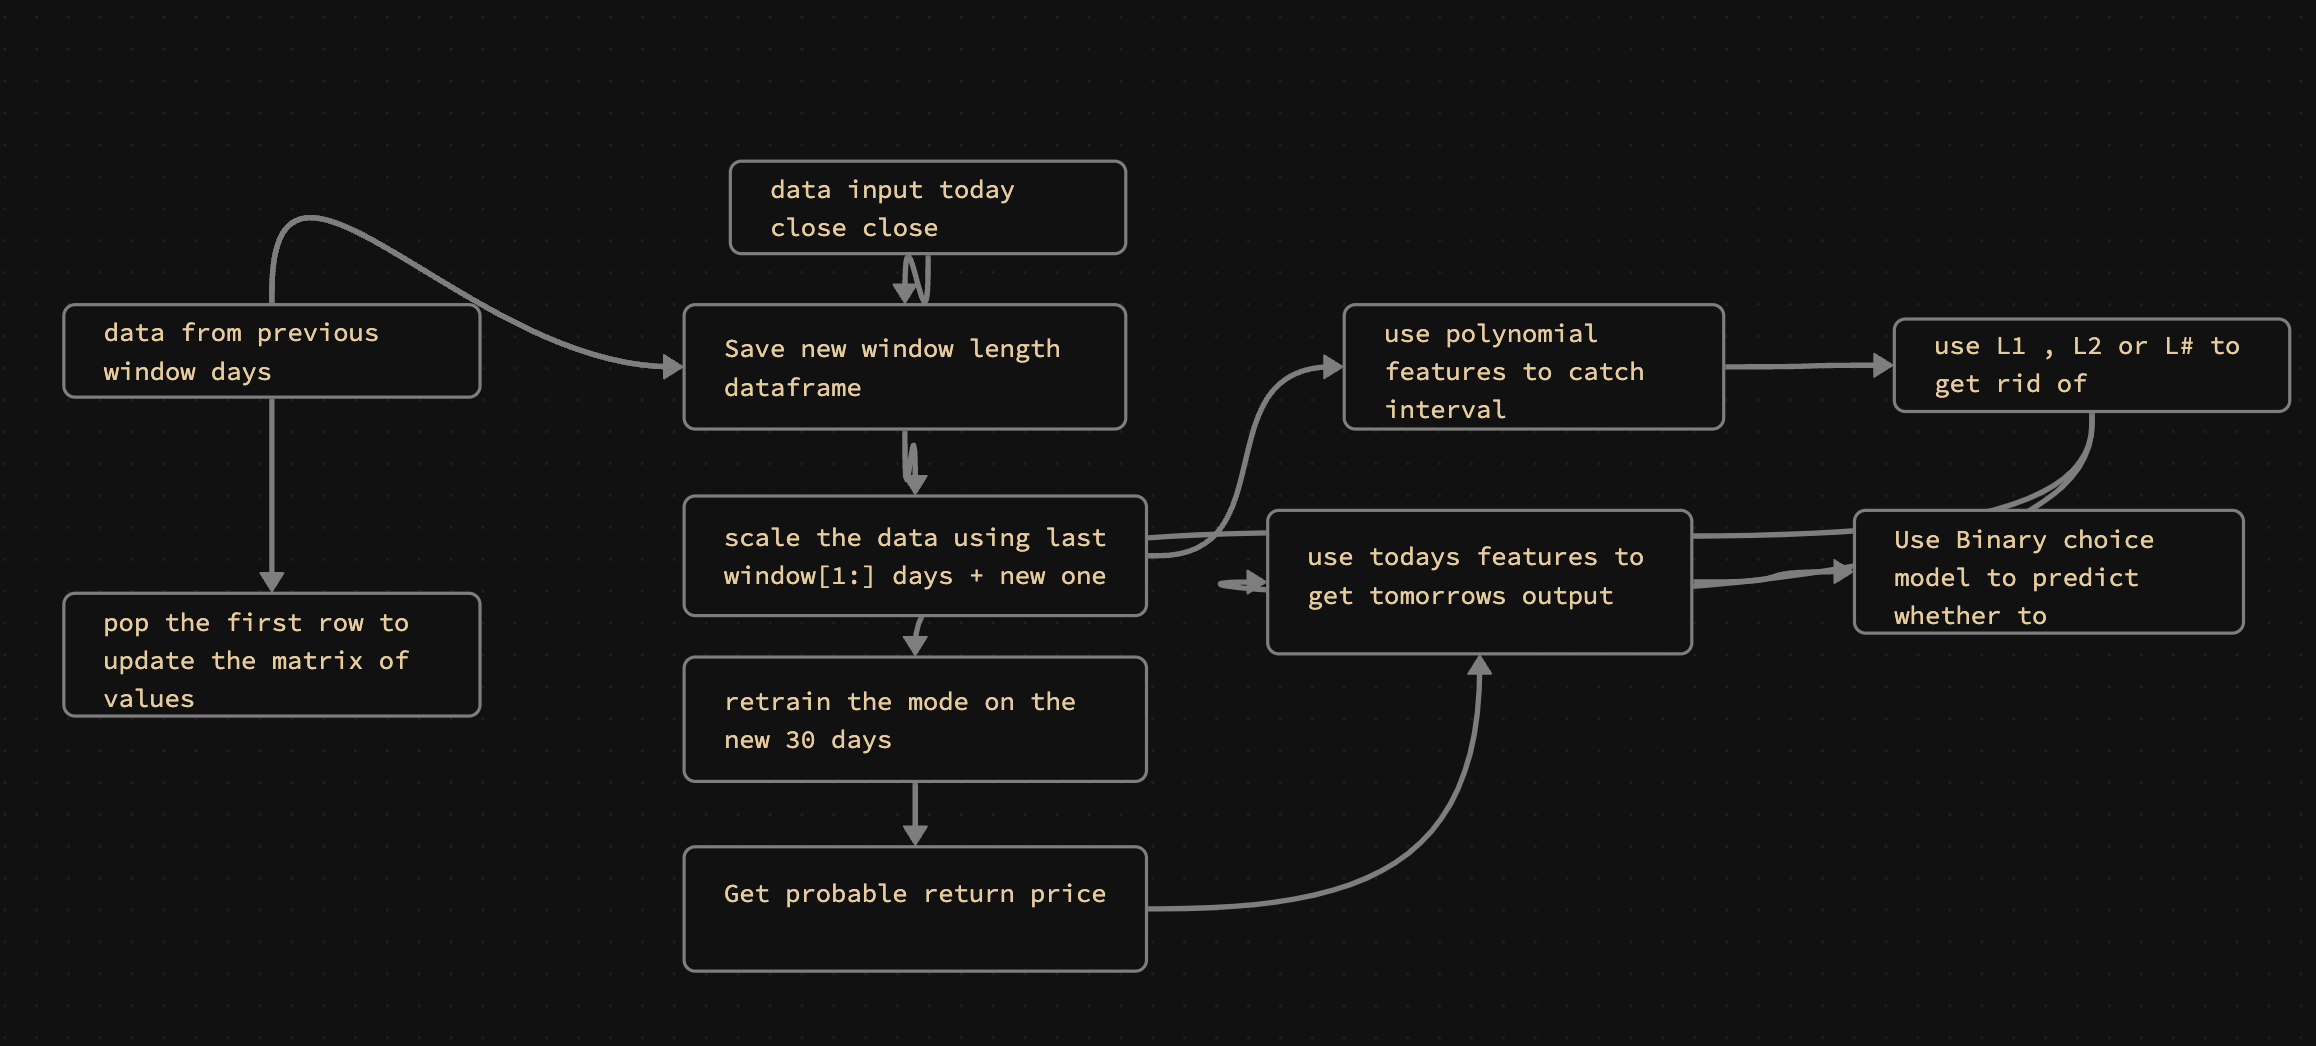

In [53]:
img = Image.open('images/Screenshot 2025-05-18 at 23.21.48.png')
display(img)


# Data

In [23]:
from dotenv import load_dotenv
import os
import pandas as pd

In [4]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

# Initialize the client
# load_dotenv('squantsteam/.env')
key = 'PKEI9TOVHQEB5ZF1J1TD'
secret = 'ahO52FhhMpcwZGwo13DG5jGrt5Efu8nWdQxpI5vl'
client = StockHistoricalDataClient(key,secret )

# Create request
request_params = StockBarsRequest(
    symbol_or_symbols=["CPB"],
    timeframe=TimeFrame.Day,
    start=datetime(2019, 12, 31),
    end=datetime(2025, 1, 1)
)

# Get data
bars = client.get_stock_bars(request_params)

# # # Convert to dataframe and save
# # df = bars.df
# # df.to_csv('spy_data_2023.csv')
# print("API Key exists:", bool(os.getenv('ALPACA_API_KEY')))
# print("Secret Key exists:", bool(os.getenv('ALPACA_SECRET_KEY')))

# # # Reinitialize client with verified keys
# # client = StockHistoricalDataClient(
# #     os.getenv('ALPACA_API_KEY'), 
# #     os.getenv('ALPACA_SECRET_KEY'),
# #     base_url=BaseURL.PAPER  # For paper trading
# # )

In [5]:
data = bars.df

In [6]:
data

open     high      low  close     volume  \
symbol timestamp                                                              
CPB    2019-12-31 05:00:00+00:00  49.25  49.4300  48.8700  49.42  1687559.0   
       2020-01-02 05:00:00+00:00  49.45  49.5585  48.3550  48.49  1905435.0   
       2020-01-03 05:00:00+00:00  48.46  48.6200  48.3100  48.43  1820508.0   
       2020-01-06 05:00:00+00:00  48.46  48.5500  47.9600  48.51  4629659.0   
       2020-01-07 05:00:00+00:00  48.17  48.5050  48.0500  48.19  2193804.0   
...                                 ...      ...      ...    ...        ...   
       2024-12-24 05:00:00+00:00  41.33  41.9250  41.2292  41.64  1101896.0   
       2024-12-26 05:00:00+00:00  41.63  41.8700  41.5700  41.72  1604847.0   
       2024-12-27 05:00:00+00:00  41.61  42.0650  41.5600  41.81  1128278.0   
       2024-12-30 05:00:00+00:00  41.74  41.8100  41.2300  41.42  1886120.0   
       2024-12-31 05:00:00+00:00  41.39  41.9400  41.3550  41.88  2189760.0   

                                  trade_count       vwap  
symbol timestamp                                          
CPB    2019-12-31 05:00:00+00:00      12578.0  49.282615  
       2020-01-02 05:00:00+00:00      16191.0  48.605254  
       2020-01-03 05:00:00+00:00      16326.0  48.449617  
       2020-01-06 05:00:00+00:00      16971.0  48.419314  
       2020-01-07 05:00:00+00:00      15312.0  48.248777  
...                                       ...        ...  
       2024-12-24 05:00:00+00:00      13678.0  41.668462  
       2024-12-26 05:00:00+00:00      18804.0  41.724250  
       2024-12-27 05:00:00+00:00      15881.0  41.779971  
       2024-12-30 05:00:00+00:00      20819.0  41.421484  
       2024-12-31 05:00:00+00:00      28113.0  41.768124  

[1259 rows x 7 columns]

In [7]:
data = data.reset_index()

In [8]:
data

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,CPB,2019-12-31 05:00:00+00:00,49.25,49.4300,48.8700,49.42,1687559.0,12578.0,49.282615
1,CPB,2020-01-02 05:00:00+00:00,49.45,49.5585,48.3550,48.49,1905435.0,16191.0,48.605254
2,CPB,2020-01-03 05:00:00+00:00,48.46,48.6200,48.3100,48.43,1820508.0,16326.0,48.449617
3,CPB,2020-01-06 05:00:00+00:00,48.46,48.5500,47.9600,48.51,4629659.0,16971.0,48.419314
4,CPB,2020-01-07 05:00:00+00:00,48.17,48.5050,48.0500,48.19,2193804.0,15312.0,48.248777
...,...,...,...,...,...,...,...,...,...
1254,CPB,2024-12-24 05:00:00+00:00,41.33,41.9250,41.2292,41.64,1101896.0,13678.0,41.668462
1255,CPB,2024-12-26 05:00:00+00:00,41.63,41.8700,41.5700,41.72,1604847.0,18804.0,41.724250
1256,CPB,2024-12-27 05:00:00+00:00,41.61,42.0650,41.5600,41.81,1128278.0,15881.0,41.779971
1257,CPB,2024-12-30 05:00:00+00:00,41.74,41.8100,41.2300,41.42,1886120.0,20819.0,41.421484


In [9]:
data = data.drop(columns=['symbol', 'timestamp'])

In [42]:
pip install lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [173]:
from sklearn.preprocessing import PowerTransformer,PolynomialFeatures,StandardScaler,RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMClassifier
from typing import Union
import numpy as np

In [208]:
from backtesting import Strategy
from backtesting.lib import crossover
import pandas as pd
from backtesting.lib import ATR


ImportError: cannot import name 'ATR' from 'backtesting.lib' (/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/backtesting/lib.py)

In [221]:
class ml_strategy(Strategy):
 # Class-level parameter declarations (required by backtesting.py)
    window_model = 7
    lag_weight = 0.9
    random_state = 42
    init_data = None  # This will be passed during bt.run()
    
    def init(self):
        """
        Initialize the strategy once at the beginning of backtest
        """
        self.tr = [0]  # True Range
        self.atr_period = 14
        # Use init_data if provided, otherwise use beginning of self.data
        warmup_length = self.window_model + 7
        # warmup_data = self.init_data.values if self.init_data is not None else self.data.df.iloc[:self.window_model].values
        warmup_data = self.init_data.values if self.init_data is not None else self.data.df.iloc[:warmup_length].values        
        # Initialize data window
        self.data_window = np.zeros((warmup_data.shape[0], warmup_data.shape[1]))
        self.data_window[:] = warmup_data

    def _accumulate_data_new(self,data_window:Union[pd.DataFrame,np.array],added_row:Union[pd.DataFrame,pd.Series ,np.array]):
        return np.vstack((data_window[1:], added_row))
    
    def _check_enough_window(self) -> None:
        if len(self.data_window) < self.window_model:
            raise ValueError('The length of window is not enough')
        
    def _instanste_window(self) ->None: # uselless if using warm up in backtesting .py
        if not hasattr(self, 'data_window'):
            self.data_window = np.zeros((self.window_model , len(self.current_row)))
            
    def _check_df(self) -> None:
        return self.data_window if not isinstance(self.data_window,pd.DataFrame) else data.values   
    
    """
    Data work functions
    """
    def __add_slop(self, slop_degree: int , latest_data:Union[pd.DataFrame,np.array]): # decided it was needed, however, good to have
        return PolynomialFeatures(degree=slop_degree, include_bias = False).fit_transform(latest_data)
    
    def __powerscaler(self,latest_data:Union[pd.DataFrame,np.array]): # decided it was needed, however, good to have
        return PowerTransformer(method='yeo-johnson').fit_transform(latest_data)
    
    def _transform_data(self) -> np.array: # we also transform volume here ! mit mgith be an error to do this  , fixed
        """
        We take last 30 inputs as data in order to power scale them using 
        sklearn PowerTransformer 
        """
        # here i made a mistake including the last row 
        data_without_lags = self.data_window[-self.window_model:-1,:] # i hate working with arrays


            
        # if not hasattr(self, '_power_transformer'):
        #     self._power_transformer = PowerTransformer(
        #         method='yeo-johnson', # for negative returns if appear
        #         standardize=True  # Also scales to mean=0, std=1
        #     )
        if not hasattr(self, '_power_transformer'):
            self._power_transformer = RobustScaler(
            )
        self._power_transformer.fit(data_without_lags) # we fit on data withoug lags
        return self._power_transformer.transform(self.data_window) #change the data WITH lags! very carefully
    def _slop_extreme(self,adjusted_data:Union[pd.DataFrame,np.array] = True) -> np.array: 
        """
        Updated version of slop function that adds Polynomials of N degree
        """
      
        # here we add
        if not hasattr(self, '_mega_slop'):
            self._mega_slop = PolynomialFeatures(degree=2, include_bias = False)
            
        if adjusted_data.ndim == 1:
            adjusted_data = adjusted_data.reshape(-1, 1)
        self._mega_slop.fit(adjusted_data[-self.window_model:,:]) # we fit on data withoug lags
        return self._mega_slop.transform(adjusted_data) #change the data with lags! very carefully
    def _data_adjusted(self):
        """
        My transformation pipeline 
        --------------------------
        input: 
        1. PowerScaler
        2. Lags of degree seven 
        3. Poly(interaction level =2)
        
        """
        self.trans_data = self._transform_data() # we power-transform data using N = window - lag - 1 observations
        # print("trans_data shape:", self.trans_data.shape)
        # here we have transformed n = window + lag features 
        # this lag function acquires n inputs and makes lag features more so , we have OHLCV + lag features 
        self.lagged_data = self._add_lags_ar(self.feature_cols) # add lags , here we don't have to think 
        # print("lagged_data shape:", self.lagged_data.shape)
        self.ml_data = self._slop_extreme(self.lagged_data) # add new features with accordance to degree of poly
        # print("ml_data shape:", self.ml_data.shape)
        # now we need to choose the best features:
        self.final_data = self._select_important_features(self.ml_data,20)
        return self.final_data# here it might work alread, need testing
        # Maybe sekect features here 
    
    def _add_lags_ar(self,feature_cols:list = None,lag_days:int = 7) -> np.array:
        """
        Add week effect to the predictions 
        Only works with arrays: as it was prohibited to work with pandas
        """
        if feature_cols is None:
            feature_indices = np.arange(self.trans_data.shape[1])
            feature_cols = self.feature_cols
        else:
            feature_indices = np.array([self.feature_cols.index(col) for col in feature_cols])
        # Initialize storage
        n_samples, n_features = self.trans_data.shape
        lagged_data = []
        feature_names = []
        feature_indices = np.arange(self.trans_data.shape[1]) if feature_cols is None else np.array([self.feature_cols.index(col) for col in feature_cols])
        # Original features
        lagged_data.append(self.trans_data[self.window_model:, feature_indices]) # we don't bloat features with diminishigly useful data 
        feature_names.extend(feature_cols)
        
        # Create lags
        for lag in range(1, lag_days + 1):
            lagged_features = np.zeros_like(self.trans_data[self.window_model:, feature_indices]) # changed to exlude bloat
            lagged_features[lag:] = self.trans_data[self.window_model:-lag, feature_indices]  # The actual lag operation
            lagged_data.append(lagged_features)
            
            # Generate names
            for i, col in enumerate(feature_cols):
                if i in feature_indices:
                    feature_names.append(f"{col}_lag_{lag}d")
        
        # Combine all features
        return np.hstack(lagged_data) #, feature_names
    def _select_important_features(self,
                                   adjusted_data:Union[pd.DataFrame,np.array], # already adjusted data here
                                #    returns_:Union[pd.DataFrame,np.array], # it's just a third row of inputs 
                                   n_features:int, 
                                   regulization:str = 'l1'                                   
                                   ):
        """
        Just regular Regulization to check for feature importance:
        coverage of Variance = R^2 fight with me!
        -----------------------
         n_features : int
            Number of top features to select
        regularization : str ('l1' or 'l2')
            Type of regularization penalty       
        Returns:
        --------
        tuple: (selected_feature_names, importance_scores)
        """
        RET_IDX = 2
        feature_indices = [i for i in range(adjusted_data.shape[1]) if i != RET_IDX]
        # 1. Prediction features (last row, exclude return column)
        self.pred_features = adjusted_data[-1:, feature_indices]  # Shape: (1, n_features)

        # 2. Training features (all rows except last, exclude return column)
        self.train_features = adjusted_data[:-1, feature_indices]  # Shape: (n-1, n_features)

        # 3. Training returns (all rows except first, returns column)
        self.train_returns = adjusted_data[1:, RET_IDX]  # Shape: (n-1,)
        # Fit Lasso model
        model = Lasso(alpha=0.01, random_state=self.random_state)
        model.fit(self.train_features, self.train_returns)  # Ensure self.train_returns is properly defined
    
        # Get importance scores (absolute coefficients)
        importance = np.abs(model.coef_)
    
        # Select top n features (handle case when n_features > available features)
        n_features = min(n_features, self.train_features.shape[1])
        top_indices = np.argsort(importance)[-n_features:][::-1]
    
        # Return selected features as array
        return self.train_features[:, top_indices], self.pred_features[:, top_indices]
        
    """
    Models functions
    """

    def _fit_model_price(self, 
                   latest_data:Union[pd.DataFrame,np.array],
                   returns_:Union[pd.DataFrame,np.array]
                #    ,
                #    model = LinearRegression
                   ): 
        model = LinearRegression()
        return model.fit(latest_data,returns_)
    
    def _predict_model_price(self,
                             latest_data:Union[pd.Series,np.array],
                             model
                             ):
        return model.predict(latest_data)
    
    def _fit_model_triplet(self, 
                        latest_data:Union[pd.DataFrame,np.array],
                        returns_:Union[pd.DataFrame,np.array],
                        params,# look here !
                        model = LGBMClassifier                   
                        ):
        """
        As you can see in convas , i wanted to stack models due to the fact that i introduced option to do nothing 
        as this can be a good money saver 
        Upd: it's worthless , validation will just kill the idea begind my model 
        """
        return model(*params).fit()       
                     
    def _predict_model_triplet(self,                            
                             latest_data:Union[pd.Series,np.array],
                             model # should be the model from binary predict                                                 
                              ):
        return model.predict(latest_data) # should return 


    """
    Logic function
    """  
    
    def _execute_order_66(self):
        """
        Apply transfromation , fit the model -> predict -> Done
        """

        eps= 1e-8
        self.train_features ,self.pred_features= self._data_adjusted()
        if (np.abs(self.train_features) < eps).all():
            return 'sell'
        else:
            self.pred_features[np.abs(self.pred_features) < eps] = eps
            noise_level = 1e-8
            self.train_features += np.random.normal(0, noise_level, self.train_features.shape)
            self.pred_features += np.random.normal(0, noise_level, self.pred_features.shape)
            # print("Data shape:", self.train_features.shape)
            # print("Min:", np.min(self.train_features), "Max:", np.max(self.train_features))
            # print("NaNs:", np.isnan(self.train_features).sum(), "Infs:", np.isinf(self.train_features).sum())
            model = self._fit_model_price(self.train_features, self.train_returns)

            predicted_return = model.predict(self.pred_features)

            return 'buy' if predicted_return > 0 else 'sell'  

    def next(self): 
        #data names 
        self.feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  

        # self.current_row = self.data.iloc[-1].values # we just need to give out a strategy a row
        self.current_row = np.array([
                                    self.data.Open[-1],  
                                        self.data.High[-1], 
                                        self.data.Low[-1], 
                                        self.data.Close[-1], 
                                        self.data.Volume[-1]
        ])
        # we need to chek out if the window is initilized yet
        
        self._instanste_window()

        self.data_window = self._accumulate_data_new(self.data_window,self.current_row) # add new, drop old

        # check enough data 
        self._check_enough_window()

        #Generate signal
        signal = self._execute_order_66()
        if signal == 'buy' and not self.position.is_long:

            # Calculate True Range
            high, low, close = self.data.High, self.data.Low, self.data.Close
            tr = max(high[-1] - low[-1], 
            abs(high[-1] - close[-2]), 
            abs(low[-1] - close[-2]))
            self.tr.append(tr)
        
            # Calculate ATR

            atr = sum(self.tr[-self.atr_period:]) / self.atr_period
            
            # Position sizing
            risk_per_trade = 0.01  # 1% of equity
            size = (self.equity * risk_per_trade) / atr
            
            self.buy(size =int(size))
        elif signal == 'sell' and self.position.is_long:
            self.sell(size = 0.75) # as we chase small profit
        else:
            return None
    

Simple offtop: I didn't use Walf-Forward Analysis in this case as I wasn't sure about the correctness of it:
- Yes, I would validate on the last 7 days before the trade and it would not make sense as market changes 
    - would've loved a comment on this ! 
- We want to see short-term abuse but i have daily data 
- I had a trouble that i used to fit(leak) data using current row in transformers + poly features so i had to waste 30 minutes on that too
- tensors are faster , literally anything is faster than DF but arrays are not optimal as multipication is faster in tensors too (10x)

In [33]:
# data = data.drop(columns=['trade_count','vwap'])
# data.head()

In [34]:
# data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']  


In [130]:
data['Volume'] = np.log1p(data['Volume'])

In [178]:
cols = data.columns.tolist()
cols

['Open', 'High', 'Low', 'Close', 'Volume']

In [179]:
cols[3], cols[2] = cols[2], cols[3]
data = data.loc[:, cols]
data.head()

,Open,High,Close,Low,Volume
0,49.25,49.4300,49.42,48.870,14.338794
1,49.45,49.5585,48.49,48.355,14.460221
2,48.46,48.6200,48.43,48.310,14.414627
3,48.46,48.5500,48.51,47.960,15.347994
4,48.17,48.5050,48.19,48.050,14.601148


In [222]:
from backtesting import Backtest

bt = Backtest(
    data=data,
    strategy=ml_strategy,
    cash=100000,
    commission=.01
)

# 3. Run with parameters
results = bt.run(
    window_model=7,
    lag_weight=0.9,
    random_state=42,
    init_data=data.iloc[:14]  # Warm-up period data
)

print(results)

/var/folders/bq/c87ppshj4m5d_hqbqb6pv2km0000gn/T/ipykernel_15682/1290112565.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(


Backtest.run:   0%|          | 0/1258 [00:00<?, ?bar/s]

/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.480e-04, tolerance: 1.914e-04
  model = cd_fast.enet_coordinate_descent(
/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-03, tolerance: 2.840e-04
  model = cd_fast.enet_coordinate_descent(
/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Start                                     0.0
End                                    1258.0
Duration                               1258.0
Exposure Time [%]                     4.68626
Equity Final [$]                    89344.444
Equity Peak [$]                      100000.0
Commissions [$]                      9753.816
Return [%]                          -10.65556
Buy & Hold Return [%]               -15.25698
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                           -10.92914
Beta                                 -0.01793
Max. Drawdown [%]                   -10.65556
Avg. Drawdown [%]                   -10.65556
Max. Drawdown Duration                 1201.0
Avg. Drawdown Duration                 1201.0
# Trades                                 29.0
Win Rate [%]                      

/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e-03, tolerance: 4.899e-04
  model = cd_fast.enet_coordinate_descent(
/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.365e-03, tolerance: 2.335e-03
  model = cd_fast.enet_coordinate_descent(
/Users/anatoliifrolov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

quick test

In [223]:
bt.plot()  # Shows the main performance plot


GridPlot(id='p3065', ...)